# qBraid QIR simulator batch job submission

In [1]:
from qbraid.runtime import QbraidProvider
from qbraid.visualization import plot_histogram
from qbraid.programs import QPROGRAM_REGISTRY

In [2]:
provider = QbraidProvider()

In [3]:
device = provider.get_device("qbraid_qir_simulator")

device.status()

<DeviceStatus.ONLINE: 'online'>

In [4]:
target_spec = device.profile.get("program_spec")

target_spec

<ProgramSpec('builtins.Module', 'pyqir')>

In [5]:
QPROGRAM_REGISTRY

{'cirq': cirq.circuits.circuit.Circuit,
 'qiskit': qiskit.circuit.quantumcircuit.QuantumCircuit,
 'pennylane': pennylane.tape.tape.QuantumTape,
 'pyquil': pyquil.quil.Program,
 'pytket': pytket._tket.circuit.Circuit,
 'braket': braket.circuits.circuit.Circuit,
 'braket_ahs': braket.ahs.analog_hamiltonian_simulation.AnalogHamiltonianSimulation,
 'openqasm3': openqasm3.ast.Program,
 'pyqir': Module,
 'cpp_pyqubo': cpp_pyqubo.Model,
 'qasm2': str,
 'qasm3': str,
 'ionq': ~IonQDict,
 'bloqade': bloqade.builder.assign.BatchAssign}

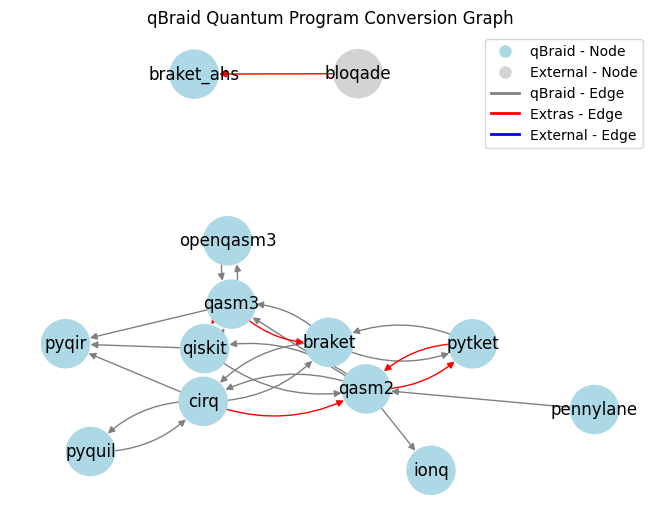

In [6]:
graph = device.scheme.conversion_graph

graph.plot(legend=True)

Create batch of GHZ state circuits using OpenQASM 3 and Cirq

In [7]:
import cirq
import qiskit

from qbraid.visualization import circuit_drawer


def qasm3_ghz() -> str:
    return """
OPENQASM 3.0;
bit[3] b;
qubit[3] q;
h q[0];
cx q[0], q[1];
cx q[1], q[2];
b[0] = measure q[0];
b[1] = measure q[1];
b[2] = measure q[2];
    """


def cirq_ghz() -> cirq.Circuit:
    """Returns Cirq GHZ circuit"""
    q0, q1, q2 = cirq.LineQubit.range(3)
    circuit = cirq.Circuit(
        cirq.ops.H(q0),
        cirq.ops.CNOT(q0, q1),
        cirq.ops.CNOT(q1, q2),
        cirq.measure((q0, q1, q2), key="result"),
    )
    return circuit


circuits = [qasm3_ghz(), cirq_ghz()]

circuit_drawer(circuits[0])

     |---|                  |---|
q0---| h |-----■------------| m |-----------
     |---|     |            |---|
            |----|            ║  |---|
q1----------| cx |-----■------║--| m |------
            |----|     |      ║  |---|
                    |----|    ║    ║  |---|
q2------------------| cx |----║----║--| m |-
                    |----|    ║    ║  |---|
                              ║    ║    ║
c0==========================================
                                   ║    ║
                                   ║    ║
c1==========================================
                                        ║
                                        ║
c2==========================================


Submit quantum jobs to remote qBraid QIR simulator and plot results

In [8]:
batch_jobs = device.run(circuits, shots=100)

In [9]:
for job in batch_jobs:
    print(job.status())

JobStatus.RUNNING
JobStatus.INITIALIZING


In [10]:
batch_results = [job.result() for job in batch_jobs]

batch_counts = [result.data.get_counts() for result in batch_results]

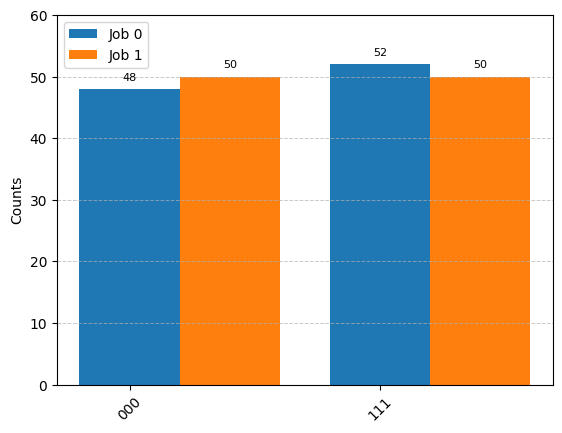

In [11]:
plot_histogram(batch_counts)